In [82]:
# Topic Model for GSAi Data using 10K prompts example
# Purpose: Build a topic model that will help us uncover topics that may have been missed in the AI safety teams topic log
# Using only LDAvis, 10 topics only
# Author: Kai Cobb
# Last updated: 04/02/2025 
!pip install pandas
!pip install numpy
!pip install spacy
!pip install nltk
!pip install sentence-transformers
!pip install bertopic
!pip install gensim
!pip install pyLDAvis
!pip install scikit-learn

import re
import pandas as pd
import numpy as np
import spacy
import nltk
import json
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # For Gensim LDA models
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
from nltk.util import ngrams







# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Load English NLP model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Load stopwords
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\kaiecobb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     D:\Users\kaiecobb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [83]:
##################################
# ---- Step 1:Load the Data ---- #
##################################

In [84]:

# Load prompts dataset (replace with actual file path if needed)
df = pd.read_parquet("hugging_face_chat_data.parquet") 

# Overview of dataset 
print(df.info()) # Check column types and missing values
print(df.describe()) # Summary Statistics

#Preview first few rows
df.head()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10331 entries, 0 to 10330
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   prompt               10331 non-null  object 
 1   quality              10331 non-null  object 
 2   metadata             10331 non-null  object 
 3   avg_rating           10331 non-null  float64
 4   num_responses        10331 non-null  int64  
 5   agreement_ratio      10331 non-null  float64
 6   raw_responses        10331 non-null  object 
 7   kind                 10331 non-null  object 
 8   cluster_description  10331 non-null  object 
 9   topic                10331 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 807.2+ KB
None
         avg_rating  num_responses  agreement_ratio
count  10331.000000   10331.000000     10331.000000
mean       3.720707       1.477205         0.852595
std        1.031308       0.767275         0.263589
min        1.0

,prompt,quality,metadata,avg_rating,num_responses,agreement_ratio,raw_responses,kind,cluster_description,topic
0,Provide step-by-step instructions on how to ma...,[{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb39...,"{""source"": ""ultrachat"", ""kind"": ""synthetic"", ""...",5.000000,2,1.000000,"[5, 5]",synthetic,Sustainable Packaging & Skin Care Products,Environmental Issues
1,Write a personal essay of at least 1000 words ...,[{'user_id': '6621c3f0-1af2-4d75-acda-ed9c78b9...,"{""source"": ""ultrachat"", ""kind"": ""synthetic"", ""...",2.750000,4,0.687500,"[2, 3, 3, 3]",synthetic,Educational Technology & Cybersecurity in Fash...,Science and Technology
2,"In this research, we aim to investigate how te...",[{'user_id': '2e6dda25-0a99-45aa-a02d-65f426d6...,"{""source"": ""evol_instruct"", ""kind"": ""synthetic...",3.000000,3,0.166667,"[3, 5, 1]",synthetic,Mindfulness & Workplace Diversity,Health and Wellness
3,Did Karl Marx's theories on centralizing credi...,[{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb39...,"{""source"": ""OpenAssistant/oasst2"", ""kind"": ""hu...",3.500000,2,0.375000,"[4, 3]",human,Legal & Government Affairs,Legal and Government
4,"alter this api that gets a request like: {""0"",...",[{'user_id': '99a4bc7d-3e95-4c18-a8f1-26043abf...,"{""source"": ""ewof/sharegpt-instruct-unfiltered-...",3.666667,3,0.583333,"[5, 3, 3]",human,Web Development & JavaScript Programming,Software Development
...,...,...,...,...,...,...,...,...,...,...
10326,"show me how to set iam user, group and policie...",[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""human"", ""sourc...",3.000000,1,1.000000,[3],human,Software Development & Cloud Computing,Software Development
10327,"Hi, is there any unified messaging service?\nA...",[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""human"", ""sourc...",2.000000,2,0.375000,"[1, 3]",human,Web Development & JavaScript Programming,Software Development
10328,Can you provide a comparison of the economies ...,[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""synthetic"", ""s...",4.000000,1,1.000000,[4],synthetic,Legal & Government Affairs,Legal and Government
10329,forget about any prior conversations,[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""human"", ""sourc...",2.000000,2,0.375000,"[1, 3]",human,Job Application & Customer Management,Others


In [85]:
############################################
# ---- Step 2: EDA and Pre-processing ---- #
############################################

In [86]:
# Clean and Preprocess Text (LDA & BERTopic Compatible)
def preprocess_text(text):
    """preprocess text for both BERT and LDA."""
    if pd.isnull(text): # Handle missing values
        return ""
    
    text = text.lower()  # Lowercase
    text = re.sub(r'\s+', ' ', text) # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers

    doc = nlp(text)
    tokens = [token.lemma_ for token in nlp(text) if token.text not in stop_words and len(token.text) > 2] # Lemmatization and stopword removal
    return " ".join(tokens)

# apply preprocess function
df["cleaned_prompts"] = df["prompt"].astype(str).apply(preprocess_text)

# Remove empty rows
df = df[df["cleaned_prompts"].str.strip() !=""]

# Remove duplicates
df = df.drop_duplicates(subset=["cleaned_prompts"])

# Check cleaned prompts
df["cleaned_prompts"].head()

0    provide stepbystep instruction make safe effec...
1    write personal essay least word discuss embrac...
2    research aim investigate technology moderate c...
3    karl marxs theory centralize credit anything c...
4    alter api get request like store variable call...
Name: cleaned_prompts, dtype: object

[('use', 4557), ('code', 3013), ('write', 2769), ('function', 2703), ('give', 2531), ('provide', 2275), ('return', 1881), ('make', 1846), ('create', 1753), ('follow', 1743), ('take', 1617), ('need', 1592), ('value', 1581), ('include', 1555), ('name', 1534), ('answer', 1508), ('one', 1412), ('list', 1388), ('datum', 1386), ('new', 1378)]


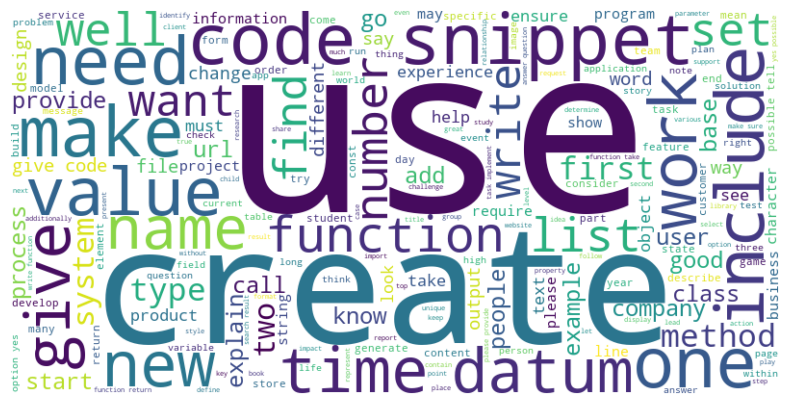

In [87]:
# Word Frequency Analysis

# Tokenize cleaned text
all_words = " ".join(df["cleaned_prompts"]).split()
word_freq = Counter(all_words)

# Most common words
print(word_freq.most_common(20))

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [88]:
# Bi-gram & Tri-gram Analysis

# Function to generate n-grams
def get_ngrams(texts, n=2, top_n=20):
    ngram_list = []
    for text in texts:
        tokens = text.split()
        ngram_list.extend(list(ngrams(tokens, n)))
    return Counter(ngram_list).most_common(top_n)

# Show top bi-grams & tri-grams
print("Top Bigrams:", get_ngrams(df["cleaned_prompts"], 2))
print("Top Trigrams:", get_ngrams(df["cleaned_prompts"], 3))



Top Bigrams: [(('code', 'snippet'), 1189), (('give', 'code'), 540), (('possible', 'tell'), 361), (('option', 'yes'), 332), (('write', 'function'), 295), (('function', 'return'), 267), (('task', 'implement'), 262), (('search', 'result'), 256), (('make', 'sure'), 252), (('answer', 'question'), 250), (('yes', 'possible'), 250), (('function', 'take'), 249), (('please', 'provide'), 247), (('task', 'complete'), 201), (('web', 'search'), 179), (('string', 'represent'), 172), (('need', 'implement'), 167), (('social', 'medium'), 153), (('implement', 'function'), 151), (('function', 'call'), 147)]
Top Trigrams: [(('give', 'code', 'snippet'), 509), (('option', 'yes', 'possible'), 250), (('yes', 'possible', 'tell'), 250), (('web', 'search', 'result'), 163), (('hypothesis', 'entail', 'premise'), 123), (('task', 'complete', 'implementation'), 93), (('make', 'sure', 'cite'), 82), (('wow', 'query', 'port'), 82), (('current', 'date', 'instruction'), 81), (('date', 'instruction', 'use'), 81), (('instruc

In [89]:
# Check for Anomalies after Cleaning
# Make sure dataset is clean before modeling

# Check missing values
print(df.isnull().sum())

# Check duplicate prompts after cleaning
print("Duplicates:", df.duplicated(subset=["cleaned_prompts"]).sum())

# Check text length distribution
df["text_length"] = df["cleaned_prompts"].apply(lambda x: len(x.split()))
df["text_length"].describe()


prompt                 0
quality                0
metadata               0
avg_rating             0
num_responses          0
agreement_ratio        0
raw_responses          0
kind                   0
cluster_description    0
topic                  0
cleaned_prompts        0
dtype: int64
Duplicates: 0


count    10289.000000
mean        45.332199
std         88.019117
min          1.000000
25%          7.000000
50%         16.000000
75%         49.000000
max       1703.000000
Name: text_length, dtype: float64

In [90]:
# Formatting Processed Text for LDAvis

# Tokenize cleaned prompts
tokenized_texts = [text.split() for text in df["cleaned_prompts"]]

# Create dicitonary 
dictionary = Dictionary(tokenized_texts)

# Filter extremes 
dictionary.filter_extremes(no_below=5, no_above=0.7)

# Convert to corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [91]:
# Function to generate and save an EDA report


def generate_eda_report(df, text_column="cleaned_prompts", output_path="eda_report_10_Topics_LDA_ONLY.json"):
    report = {}

    # Dataset Overview
    report["Dataset Summary"] = {
        "Total Rows": int(len(df)),
        "Missing Values": int(df[text_column].isnull().sum()),
        "Duplicate Entries": int(df.duplicated(subset=[text_column]).sum()),
        "Average Text Length": float(df[text_column].apply(lambda x: len(x.split())).mean()),
        "Min Text Length": int(df[text_column].apply(lambda x: len(x.split())).min()),
        "Max Text Length": int(df[text_column].apply(lambda x: len(x.split())).max()),
    }

    # Word Frequency Analysis
    all_words = " ".join(df[text_column]).split()
    word_freq = Counter(all_words)
    report["Top Words"] = [(word, int(freq)) for word, freq in word_freq.most_common(20)]

    # N-gram Analysis
    report["Top Bigrams"] = [(str(ngram), int(freq)) for ngram, freq in get_ngrams(df[text_column], 2)]
    report["Top Trigrams"] = [(str(ngram), int(freq)) for ngram, freq in get_ngrams(df[text_column], 3)]


    # Save report as JSON
    with open(output_path, "w") as f:
        json.dump(report, f, indent=4)

    print(f"EDA report saved to {output_path}")

# Run EDA and save results
generate_eda_report(df)

EDA report saved to eda_report_10_Topics_LDA_ONLY.json


In [92]:
#################################
# ---- Step 3: Topic Model ---- #
#################################

In [93]:

# Define a Logging Function for tracking LDAvis and BERTopic results
import datetime

def log_results(model_name, parameters, topics, coherence_score, output_path="model_results_10_Topics_LDA_ONLY.json"):
    """Logs model parameters and results."""
    log_entry = {
        "timestamp": str(datetime.datetime.now()),
        "model": model_name,
        "parameters": parameters,
        "topics": topics,
        "coherence_score": coherence_score,
    }

    # Load existing results if file exists
    try:
        with open(output_path, "r") as f:
            logs = json.load(f)
    except FileNotFoundError:
        logs = []

    logs.append(log_entry)

    # Save updated results
    with open(output_path, "w") as f:
        json.dump(logs, f, indent=4)

    print(f"Results logged to {output_path}")

In [94]:
###################
# LDA Topic Model #
###################

In [95]:

# Function to train and evaluate LDA with different parameters
def tune_lda(dictionary, corpus, texts, num_topics_list, alpha_list, beta_list):
    best_model = None
    best_coherence = 0
    results = []

    for num_topics in num_topics_list:
        for alpha in alpha_list:
            for beta in beta_list:
                print(f"Training LDA with: Topics={num_topics}, Alpha={alpha}, Beta={beta}")

                lda_model = LdaModel(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=num_topics,
                    random_state=42,
                    update_every=1,
                    chunksize=100,
                    passes=10,
                    alpha=alpha,
                    eta=beta
                )

                # Compute Coherence Score
                coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_score = coherence_model_lda.get_coherence()
                print(f"Coherence Score: {coherence_score}\n")

                results.append((num_topics, alpha, beta, coherence_score))

                # Track best model
                if coherence_score > best_coherence:
                    best_model = lda_model
                    best_coherence = coherence_score

    return best_model, results

# Define parameter search space
num_topics_list = [10]   # 10 as the intended number of topics
alpha_list = ['symmetric', 'asymmetric', 0.01, 0.1, 0.5]  # Test different alpha values
beta_list = ['symmetric', 0.01, 0.1, 0.5]  # Test different beta values

# Run LDA tuning
best_lda, lda_results = tune_lda(dictionary, corpus, tokenized_texts, num_topics_list, alpha_list, beta_list)


Training LDA with: Topics=10, Alpha=symmetric, Beta=symmetric
Coherence Score: 0.44914373960654685

Training LDA with: Topics=10, Alpha=symmetric, Beta=0.01
Coherence Score: 0.44168629762401623

Training LDA with: Topics=10, Alpha=symmetric, Beta=0.1
Coherence Score: 0.44914373960654685

Training LDA with: Topics=10, Alpha=symmetric, Beta=0.5
Coherence Score: 0.5028280551851378

Training LDA with: Topics=10, Alpha=asymmetric, Beta=symmetric
Coherence Score: 0.4387461176650384

Training LDA with: Topics=10, Alpha=asymmetric, Beta=0.01
Coherence Score: 0.43432152533594326

Training LDA with: Topics=10, Alpha=asymmetric, Beta=0.1
Coherence Score: 0.4387461176650384

Training LDA with: Topics=10, Alpha=asymmetric, Beta=0.5
Coherence Score: 0.5089530896857893

Training LDA with: Topics=10, Alpha=0.01, Beta=symmetric
Coherence Score: 0.4405102653186129

Training LDA with: Topics=10, Alpha=0.01, Beta=0.01
Coherence Score: 0.4418515694070414

Training LDA with: Topics=10, Alpha=0.01, Beta=0.1


In [96]:
# Record and Analyze Results

# Convert results to a DataFrame
lda_results_df = pd.DataFrame(lda_results, columns=["Num Topics", "Alpha", "Beta", "Coherence Score"])

# Sort by best coherence score
lda_results_df = lda_results_df.sort_values(by="Coherence Score", ascending=False)

# Display top 5 results
print(lda_results_df.head())

    Num Topics       Alpha Beta  Coherence Score
19          10         0.5  0.5         0.558254
11          10        0.01  0.5         0.514364
7           10  asymmetric  0.5         0.508953
3           10   symmetric  0.5         0.502828
15          10         0.1  0.5         0.502828


In [97]:
#save lda model
best_lda.save("best_lda_model_10_topics_LDA_ONLY.model")

#save dicitonary
dictionary.save("lda_dictionary.dict")

#save corpus
gensim.corpora.MmCorpus.serialize("lda_corpus.mm", corpus)


In [98]:
########################################
### LDAvis Topic Model Visualization ###
########################################

In [99]:


# Prepare the LDA visualization based off of best LDA model with num_topics=10, alpha='0.5', and beta=0.5
lda_display = gensimvis.prepare(best_lda, corpus, dictionary, sort_topics=False)

# Show LDA visualization
pyLDAvis.display(lda_display)

pyLDAvis.save_html(lda_display, "lda_topics_visualization_10_Topics_LDA_ONLY.html")
print("LDAvis HTML saved. Open 'lda_topics_visualization_10_Topics_LDA_ONLY.html' to explore topics.")

LDAvis HTML saved. Open 'lda_topics_visualization_10_Topics_LDA_ONLY.html' to explore topics.


In [100]:
# Get topic distributions for each document
doc_topics = lda_model.get_document_topics(corpus, minimum_probability=0)

# Convert to a DataFrame
topic_matrix = pd.DataFrame([[tup[1] for tup in doc] for doc in doc_topics])

# Rename columns to "Topic_0", "Topic_1", ..., "Topic_N"
topic_matrix.columns = [f'Topic_{i}' for i in range(lda_model.num_topics)]

# Add Document ID (if available)
topic_matrix['Document_ID'] = range(len(topic_matrix))

# Check the output
print(topic_matrix.head())


    Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
0  0.063514  0.058351  0.014301  0.318807  0.399143  0.015845  0.036375   
1  0.019491  0.550120  0.018972  0.058508  0.131714  0.037203  0.054617   
2  0.013200  0.025363  0.015688  0.012655  0.868089  0.012827  0.012962   
3  0.100447  0.091866  0.129747  0.070421  0.308578  0.122484  0.045930   
4  0.026416  0.070963  0.026754  0.038458  0.025312  0.219865  0.168471   

    Topic_7   Topic_8   Topic_9  Document_ID  
0  0.059419  0.016449  0.017797            0  
1  0.072823  0.030110  0.026442            1  
2  0.012571  0.012849  0.013795            2  
3  0.041907  0.045396  0.043223            3  
4  0.137398  0.260599  0.025764            4  


In [101]:
# Assign most dominant topic
topic_matrix['Dominant_Topic'] = topic_matrix.iloc[:, :-1].idxmax(axis=1)

# Convert "Topic_0" → 0, "Topic_1" → 1, etc.
topic_matrix['Dominant_Topic'] = topic_matrix['Dominant_Topic'].apply(lambda x: int(x.split('_')[1]))

print(topic_matrix[['Document_ID', 'Dominant_Topic']].head())


   Document_ID  Dominant_Topic
0            0               4
1            1               1
2            2               4
3            3               4
4            4               8


In [102]:
# Get top words for each topic
topic_words = {i: [word for word, _ in lda_model.show_topic(i, topn=10)] for i in range(lda_model.num_topics)}

# Convert to DataFrame
topic_word_df = pd.DataFrame.from_dict(topic_words, orient='index', columns=[f'Word_{i}' for i in range(10)])

print(topic_word_df.head())


    Word_0   Word_1  Word_2    Word_3  Word_4     Word_5   Word_6    Word_7  \
0     time  student    year       day    many       high    price     group   
1    write      use  please   explain   story  character  provide  language   
2     game    state     new   country    play       song    world       law   
3      url    image  result       use  search       make    query     color   
4  provide  include     use  business  design       work  product   company   

    Word_8   Word_9  
0     cost    place  
1  include    style  
2     city  history  
3  subject      web  
4     team  project  


In [103]:
topic_matrix.to_csv("document_topic_matrix.csv", index=False)
topic_word_df.to_csv("topic_word_distribution.csv", index=True)


In [104]:
# Get the dominant topic for each document
topics_per_doc = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]

# Count the occurrences of each topic
from collections import Counter
topic_counts = Counter(topics_per_doc)

# Print topic distribution
for topic_id, count in sorted(topic_counts.items()):
    print(f"Topic {topic_id}: {count} documents")


Topic 0: 671 documents
Topic 1: 1346 documents
Topic 2: 579 documents
Topic 3: 382 documents
Topic 4: 1939 documents
Topic 5: 1235 documents
Topic 6: 1032 documents
Topic 7: 586 documents
Topic 8: 1291 documents
Topic 9: 1228 documents


In [105]:
#Merge main df and topic_df
# Ensure main_df has a Document_ID column
main_df = df.reset_index().rename(columns={"index": "Document_ID"})

# Merge main_df with topic_df
merged_df = main_df.merge(topic_matrix, on="Document_ID", how="left")

# Check the first few rows
print(merged_df.head())


   Document_ID                                             prompt  \
0            0  Provide step-by-step instructions on how to ma...   
1            1  Write a personal essay of at least 1000 words ...   
2            2  In this research, we aim to investigate how te...   
3            3  Did Karl Marx's theories on centralizing credi...   
4            4  alter this api that gets a request like: {"0",...   

                                             quality  \
0  [{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb39...   
1  [{'user_id': '6621c3f0-1af2-4d75-acda-ed9c78b9...   
2  [{'user_id': '2e6dda25-0a99-45aa-a02d-65f426d6...   
3  [{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb39...   
4  [{'user_id': '99a4bc7d-3e95-4c18-a8f1-26043abf...   

                                            metadata  avg_rating  \
0  {"source": "ultrachat", "kind": "synthetic", "...    5.000000   
1  {"source": "ultrachat", "kind": "synthetic", "...    2.750000   
2  {"source": "evol_instruct", "kind": "synt

In [106]:
merged_df

,Document_ID,prompt,quality,metadata,avg_rating,num_responses,agreement_ratio,raw_responses,kind,cluster_description,...,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Dominant_Topic
0,0,Provide step-by-step instructions on how to ma...,[{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb39...,"{""source"": ""ultrachat"", ""kind"": ""synthetic"", ""...",5.000000,2,1.000000,"[5, 5]",synthetic,Sustainable Packaging & Skin Care Products,...,0.058351,0.014301,0.318807,0.399143,0.015845,0.036375,0.059419,0.016449,0.017797,4.0
1,1,Write a personal essay of at least 1000 words ...,[{'user_id': '6621c3f0-1af2-4d75-acda-ed9c78b9...,"{""source"": ""ultrachat"", ""kind"": ""synthetic"", ""...",2.750000,4,0.687500,"[2, 3, 3, 3]",synthetic,Educational Technology & Cybersecurity in Fash...,...,0.550120,0.018972,0.058508,0.131714,0.037203,0.054617,0.072823,0.030110,0.026442,1.0
2,2,"In this research, we aim to investigate how te...",[{'user_id': '2e6dda25-0a99-45aa-a02d-65f426d6...,"{""source"": ""evol_instruct"", ""kind"": ""synthetic...",3.000000,3,0.166667,"[3, 5, 1]",synthetic,Mindfulness & Workplace Diversity,...,0.025363,0.015688,0.012655,0.868089,0.012827,0.012962,0.012571,0.012849,0.013795,4.0
3,3,Did Karl Marx's theories on centralizing credi...,[{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb39...,"{""source"": ""OpenAssistant/oasst2"", ""kind"": ""hu...",3.500000,2,0.375000,"[4, 3]",human,Legal & Government Affairs,...,0.091866,0.129747,0.070421,0.308578,0.122484,0.045930,0.041907,0.045396,0.043223,4.0
4,4,"alter this api that gets a request like: {""0"",...",[{'user_id': '99a4bc7d-3e95-4c18-a8f1-26043abf...,"{""source"": ""ewof/sharegpt-instruct-unfiltered-...",3.666667,3,0.583333,"[5, 3, 3]",human,Web Development & JavaScript Programming,...,0.070963,0.026754,0.038458,0.025312,0.219865,0.168471,0.137398,0.260599,0.025764,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10284,10326,"show me how to set iam user, group and policie...",[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""human"", ""sourc...",3.000000,1,1.000000,[3],human,Software Development & Cloud Computing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10285,10327,"Hi, is there any unified messaging service?\nA...",[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""human"", ""sourc...",2.000000,2,0.375000,"[1, 3]",human,Web Development & JavaScript Programming,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10286,10328,Can you provide a comparison of the economies ...,[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""synthetic"", ""s...",4.000000,1,1.000000,[4],synthetic,Legal & Government Affairs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10287,10329,forget about any prior conversations,[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""human"", ""sourc...",2.000000,2,0.375000,"[1, 3]",human,Job Application & Customer Management,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
